In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
import  sklearn.metrics as met
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score, explained_variance_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### В задании сказано не использовать поле Week, но убедимся, що между ним и целевой перемнной нет взаимосвязи

In [3]:
grouped = train.groupby(['Week','target'])['Id'].count().reset_index()

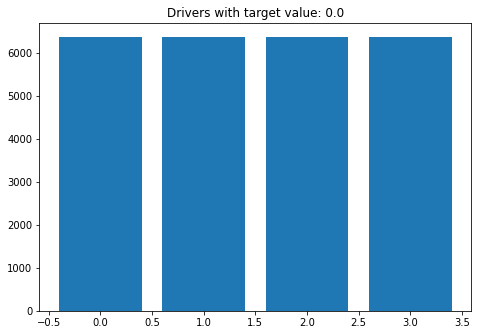

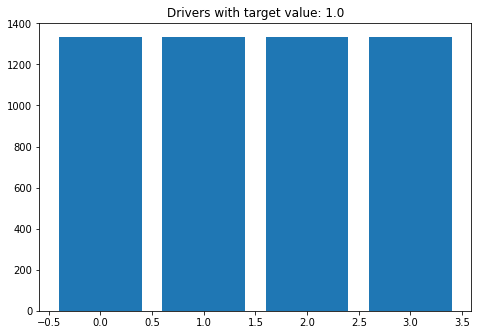

In [4]:
for i in grouped.target.unique():
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    weeks = grouped[grouped.target==i]['Week']
    users = grouped[grouped.target==i]['Id']
    ax.bar(weeks,users)
    ax.set_title(f'Drivers with target value: {i}')
    plt.show()

#### С помощью .info() проверяем на наличие NaN значений

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30860 entries, 0 to 30859
Data columns (total 52 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      30860 non-null  int64  
 1   Week    30860 non-null  int64  
 2   V1      30812 non-null  float64
 3   V2      30812 non-null  float64
 4   V3      23760 non-null  float64
 5   V4      23760 non-null  float64
 6   V5      23760 non-null  float64
 7   V6      23760 non-null  float64
 8   V7      23760 non-null  float64
 9   V8      23760 non-null  float64
 10  V9      23760 non-null  float64
 11  V10     23760 non-null  float64
 12  V11     23760 non-null  float64
 13  V12     23760 non-null  float64
 14  V13     23760 non-null  float64
 15  V14     23760 non-null  float64
 16  V15     23760 non-null  float64
 17  V16     23760 non-null  float64
 18  V17     23760 non-null  float64
 19  V18     23760 non-null  float64
 20  V19     23760 non-null  float64
 21  V20     23760 non-null  float64
 22

#### Так как нет контекста данных, то попробуем заполнить путсые значния интерполяцией, таким образом избежим изменений в распределениях признаков

In [6]:
train_int = train.interpolate()
test_int = test.interpolate()

#### В итоге результаты были ниже ожидаемых и мы перешли на заполнение нулями (дало лучше результаты)

In [7]:
train_int = train.fillna(0)
test_int = test.fillna(0)

### Дальше так как на каждый ID может быть несколько записей, то групируем по ID

In [8]:
df_train = train_int
df_test = test_int

df_train_sum = df_train.groupby("Id").sum()
df_train_max = df_train.groupby("Id").max()
df_train_min = df_train.groupby("Id").min()
df_train_median = df_train.groupby("Id").median()

# TEST

df_test_sum = df_test.groupby("Id").sum()
df_test_max = df_test.groupby("Id").max()
df_test_min = df_test.groupby("Id").min()
df_test_median = df_test.groupby("Id").median()

# TRAIN
df_train_median.drop(['Week'], axis=1, inplace=True)
df_train_sum.drop(["Week", 'target'], axis=1, inplace=True)
df_train_max.drop(["Week", 'target'], axis=1, inplace=True)
df_train_min.drop(["Week", 'target'], axis=1, inplace=True)

columns_maps = lambda param: dict([(x, f"{x}_{param}") for x in df_test.columns])


df_train_sum  = df_train_sum.rename(columns=columns_maps("sum"))
df_train_max  = df_train_max.rename(columns=columns_maps("max"))
df_train_min  = df_train_min.rename(columns=columns_maps("min"))
df_train_median  = df_train_median.rename(columns=columns_maps("median"))

# TEST

df_test_sum.drop(["Week"], axis=1, inplace=True)
df_test_max.drop(["Week"], axis=1, inplace=True)
df_test_min.drop(["Week"], axis=1, inplace=True)
df_test_median.drop(["Week"], axis=1, inplace=True)

df_test_sum  = df_test_sum.rename(columns=columns_maps("sum"))
df_test_max  = df_test_max.rename(columns=columns_maps("max"))
df_test_min  = df_test_min.rename(columns=columns_maps("min"))
df_test_median  = df_test_median.rename(columns=columns_maps("median"))

# CONCATENATING
df_train_new = pd.concat([ df_train_sum,df_train_max,df_train_min, df_train_median], axis=1)
df_test_new  = pd.concat([ df_test_sum, df_test_max, df_test_min, df_test_median], axis=1)

df_train_new.head()

,V1_sum,V2_sum,V3_sum,V4_sum,V5_sum,V6_sum,V7_sum,V8_sum,V9_sum,V10_sum,...,P19_median,P20_median,P21_median,P22_median,P23_median,P24_median,P25_median,P26_median,P27_median,target
Id,,,,,,,,,,,,,,,,,,,,,
-9217315602200933985,1.454545,28.0,0.284639,0.313905,0.000000,0.000000,1.072792,0.666598,0.000000,0.000000,...,26.758333,4.930,10.743407,243.0,0.000000,4.930000,0.000000,1307.5,0.149287,0.0
-9213274821386443078,0.102564,4.0,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,1.137255,0.000000,...,13.025000,4.900,7.935784,120.5,0.000000,4.900000,0.887255,3448.5,0.000000,1.0
-9208710115890940128,2.256410,88.0,0.063659,0.092231,0.265664,0.063659,0.810025,0.318296,0.421554,0.085714,...,25.466667,4.925,10.870752,606.5,0.054887,4.917095,0.575188,4265.0,0.771930,0.0
-9205482426769313939,0.000000,0.0,0.284727,0.143233,0.031250,0.031250,0.329887,0.474906,0.285244,0.064286,...,26.858333,4.855,8.854241,322.5,0.000000,4.840781,0.625446,4597.0,0.628571,0.0
-9204742353296425998,0.307692,4.0,0.000000,0.734230,0.000000,0.000000,1.263894,0.269830,0.024390,0.000000,...,13.758333,4.970,7.255195,215.0,0.000000,4.967983,0.368132,5040.0,0.200750,0.0


# Train model

In [9]:
df_train_new
df_test_new

first_q1 = 0.05
second_q3 = 0.98

for column in df_test_new.columns:
  Q1 = df_train_new[column].quantile(first_q1)
  Q3 = df_train_new[column].quantile(second_q3)
  IQR = Q3 - Q1
  df_train_new = df_train_new[(df_train_new[column] >= Q1 - 1.5*IQR) & 
                        (df_train_new[column] <= Q3 + 1.5*IQR)]

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train_new.drop(["target"], axis=1), df_train_new.target, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((4516, 196), (1936, 196))

### GradientBoostingClassifier

0.9706716247117947


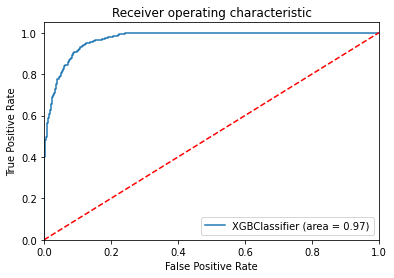

In [11]:
clf_g = GradientBoostingClassifier()

clf_g.fit(X_train, y_train)

y_predict_train = clf_g.predict_proba(X_train)[:,1]
y_predict_test = clf_g.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))
#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


### XGBClassifier (тренировка параметров+результаты)

/Users/s.zinchenko/.local/share/virtualenvs/notebooks-1OY_9XZP/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:31:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9743334159253872


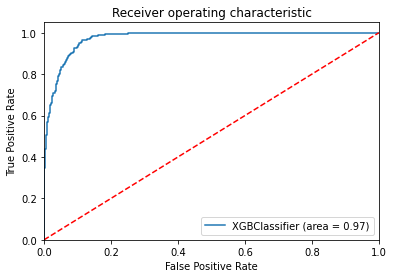

In [12]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
y_predict_train = clf_xgb.predict_proba(X_train)[:,1]
y_predict_test = clf_xgb.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))

#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
%%time
gbr = XGBClassifier()
grid = {
    'gamma': [0.1],
    'learning_rate': [0.4],
    'max_depth': [3],
    'n_estimators': [100],
    'reg_alpha': [0],
    'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
    'booster' : ['gbtree'],
}


n_splits = 3
clf31 = GridSearchCV(gbr, grid, n_jobs=-1,
                     cv=KFold(n_splits=n_splits, shuffle=True),
                     scoring='roc_auc',
                     verbose=4, refit=True)
clf31.fit(X_train, y_train)

print()
print(clf31.best_params_)
print(clf31.best_score_)
print(clf31.best_estimator_)

In [ ]:
%%time
gbr = XGBClassifier()
grid = {
    'eta': np.arange(0.1, 0.26, 0.05),
    'min_child_weight': np.arange(1, 5, 0.5).tolist(),
    'gamma': [5],
    'subsample': np.arange(0.5, 1.0, 0.11).tolist(),
    'colsample_bytree': np.arange(0.5, 1.0, 0.11).tolist()
}


n_splits = 3
clf31 = GridSearchCV(gbr, grid, n_jobs=-1,
                     cv=KFold(n_splits=n_splits, shuffle=True),
                     scoring='roc_auc',
                     verbose=4, refit=True)
clf31.fit(X_train, y_train)

print()
print(clf31.best_params_)
print(clf31.best_score_)
print(clf31.best_estimator_)

/Users/s.zinchenko/.local/share/virtualenvs/notebooks-1OY_9XZP/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:32:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9736316987041874


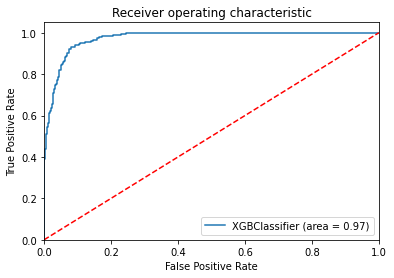

In [13]:
clf_xgb = XGBClassifier(booster = 'dart', learning_rate=0.4, n_estimators=106, max_depth=3, min_child_weight=0)
clf_xgb.fit(X_train, y_train)
y_predict_train = clf_xgb.predict_proba(X_train)[:,1]
y_predict_test = clf_xgb.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))

#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Попробуем применить ансамбль из BaggingClassifier и XGBClassifier

0.9780746468243986


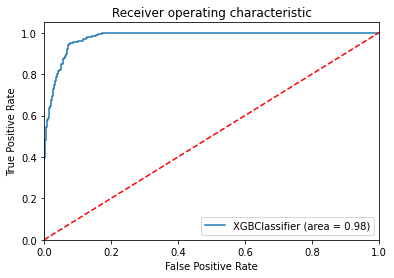

In [46]:
clf_bagging = BaggingClassifier(base_estimator=XGBClassifier(booster = 'dart', learning_rate=0.4, n_estimators=106, max_depth=3, min_child_weight=0), n_jobs=-1)
clf_bagging.fit(X_train, y_train)
y_predict_train = clf_bagging.predict_proba(X_train)[:,1]
y_predict_test = clf_bagging.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))

#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### LGBMClassifier (тренировка параметров + результаты)

In [ ]:
gkf = KFold(n_splits=5, shuffle=True, random_state=42).split(X=X_train, y=y_train)

param_grid = {
    'num_leaves': [5, 10, 31, 127],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [50],
    'lambda_l1': [0],
    'lambda_l2': [1],
    'learning_rate': [0.5],
    'boosting_type': ['gbdt', 'rf', 'dart']
}

lgb_estimator = lgb.LGBMClassifier(objective='binary', metric='auc')

gsearch = GridSearchCV(estimator=lgb_estimator, param_grid=param_grid, cv=gkf)
lgb_model = gsearch.fit(X=X_train, y=y_train)

print(lgb_model.best_params_, lgb_model.best_score_)

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=1.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
0.9748838194600749
0.9748838194600749


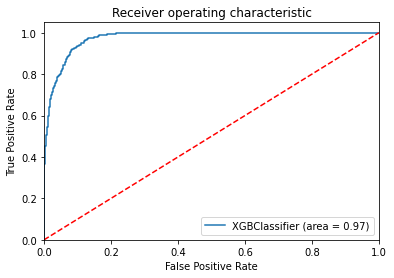

In [43]:
clf_lbgmc= LGBMClassifier(is_unbalance=True, objective='binary',
                          boosting_type='dart', lambda_l1=1, lambda_l2=1.5,
                          learning_rate=0.3, min_data_in_leaf=200, num_leaves=27,
                          reg_alpha=0.1)
clf_lbgmc.fit(X_train, y_train)
y_predict_train = clf_lbgmc.predict_proba(X_train)[:,1]
y_predict_test = clf_lbgmc.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))

print(roc_auc_score(y_test, y_predict_test))

#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### Попробуем применить ансамбль из BaggingClassifier и LGBMClassifier

0.9731493863284302


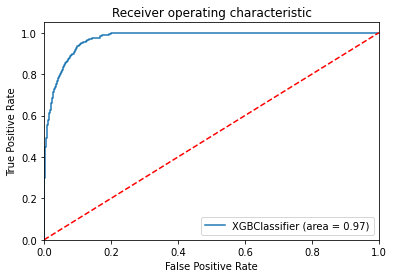

In [16]:
clf_bagging = BaggingClassifier(base_estimator=LGBMClassifier(is_unbalance=True, objective='binary',
                                                          boosting_type='dart', lambda_l1=1, lambda_l2=1,
                                                          learning_rate=0.1, min_data_in_leaf=100, num_leaves=127,
                                                          reg_alpha=0.1), n_jobs=-1)
clf_bagging.fit(X_train, y_train)
y_predict_train = clf_bagging.predict_proba(X_train)[:,1]
y_predict_test = clf_bagging.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, y_predict_test))

#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Попробуем использовать ensemble из BaggingClassifier,XGBClassifier,LGBMClassifier

0.9754796171007163


/Users/s.zinchenko/.local/share/virtualenvs/notebooks-1OY_9XZP/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


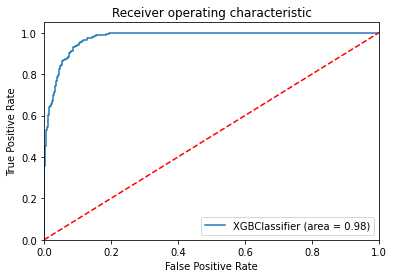

In [20]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingRegressor, VotingClassifier
name_model_1 = 'BaggingClassifier'
name_model_2 = 'XGBClassifier'
name_model_3 = 'LGBMClassifier'


clf1 =BaggingClassifier(base_estimator=LGBMClassifier(is_unbalance=True, objective='binary',
                                                      boosting_type='dart', lambda_l1=1, lambda_l2=1,
                                                      learning_rate=0.1, min_data_in_leaf=100, num_leaves=27,
                                                      reg_alpha=0.1), n_jobs=-1)



clf2 =  XGBClassifier(booster = 'gbtree', learning_rate=0.4, n_estimators=100, max_depth=3, min_child_weight=0, eval_metric='auc', gamma = 0.1, reg_alpha = 0)

clf3 = LGBMClassifier(is_unbalance=True, objective='binary',
                      boosting_type='dart', lambda_l1=1, lambda_l2=1,
                      learning_rate=0.1, min_data_in_leaf=100, num_leaves=27,
                      reg_alpha=0.1)


ensemble=VotingClassifier(estimators=[(name_model_1, clf1),
                                      (name_model_3, clf3),
                                      (name_model_2, clf2)],

                          n_jobs=-1, voting='soft',
                          verbose=True).fit(X_train, y_train)


y_predict_train = ensemble.predict_proba(X_train)[:,1]
y_predict_test = ensemble.predict_proba(X_test)[:,1]


from sklearn.metrics import confusion_matrix

fpr, tpr, thresholds = met.roc_curve(y_test, y_predict_test, pos_label=2)

print(roc_auc_score(y_test, y_predict_test))
#print(classification_report(y_test, predictions))
#print(accuracy_score(y_test, predictions ))
fpr, tpr, thresholds = roc_curve(y_test, y_predict_test)
plt.figure()
plt.plot(fpr, tpr, label='XGBClassifier (area = %0.2f)' % roc_auc_score(y_test, y_predict_test))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Лучше всего показала модель с использованием ансамбля из BaggingClassifier и XGBClassifier


### Как можно улучшить
1. посмотреть, как ниже указано, основные фичи которые использует модель
2. для дальнейшего усовершенствования полезно было бы уменьшить размерность данных с помощью UMAP, PCA, SVD и изобразить распределения в 2-х или трехмерном пространстве

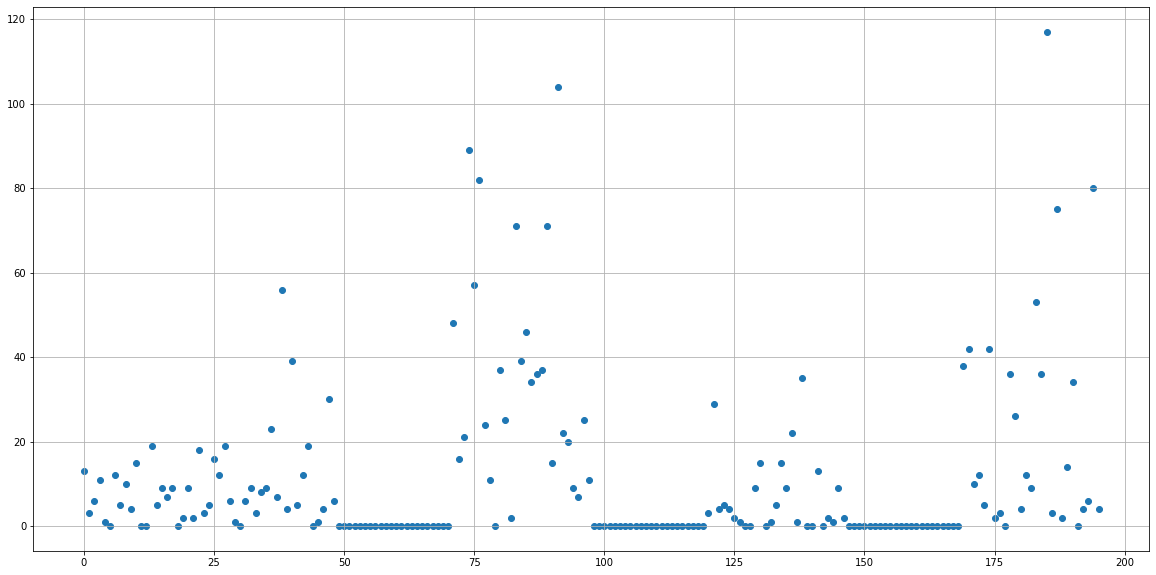

In [618]:
x_plot = list(range(len(clf_lbgmc.feature_importances_)))
importances = list(clf_lbgmc.feature_importances_)

plt.figure(figsize=(20,10))
plt.grid(True)
plt.scatter(x_plot,importances)
plt.show()

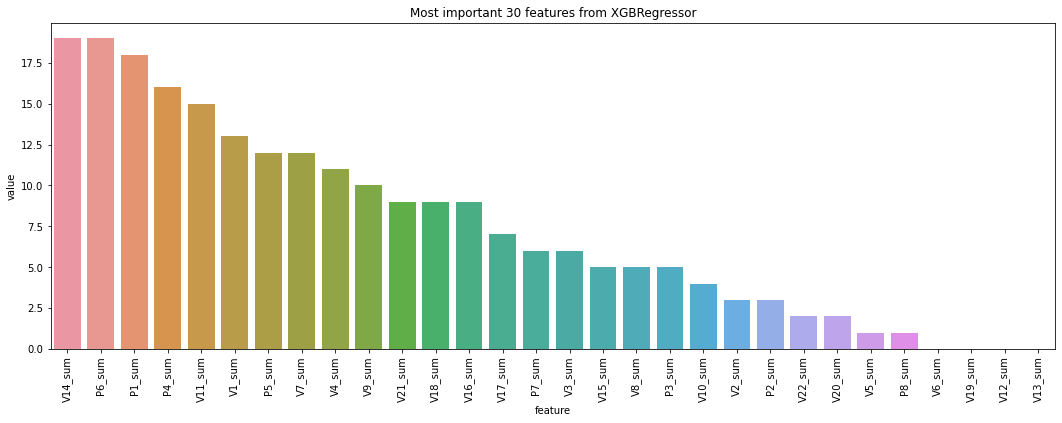

In [619]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(data, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=data['feature'], y=data['value'])
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

importances = list(clf_lbgmc.feature_importances_)


feat_imp = dict((value, name) for value, name in zip(X_train.columns, importances))
first_elem = 30

df_features = pd.DataFrame({'feature':list(feat_imp.keys())[:first_elem], 'value':list(feat_imp.values())[:first_elem] }).reset_index()

model_name = 'XGBRegressor'
title = f'Most important {first_elem} features from {model_name}'
df_features = df_features.sort_values(by=['value'], ascending=False)
barplot(df_features, title=title)

In [620]:
df_test_new.values

array([[4.10256410e-01, 1.20000000e+01, 1.70426065e-02, ...,
        5.57097605e-01, 1.34950000e+03, 3.79072682e-01],
       [2.05128205e-01, 4.00000000e+00, 0.00000000e+00, ...,
        8.29414838e-01, 1.87650000e+03, 4.10135841e-02],
       [6.45161290e-01, 8.00000000e+00, 0.00000000e+00, ...,
        7.99407115e-01, 9.59000000e+02, 0.00000000e+00],
       ...,
       [2.22222222e-01, 4.00000000e+00, 1.74603175e-01, ...,
        0.00000000e+00, 3.14700000e+03, 1.98051948e-01],
       [3.07692308e-01, 8.00000000e+00, 9.80861244e-02, ...,
        4.28571429e-01, 2.20750000e+03, 1.73444976e-01],
       [4.10256410e-01, 8.00000000e+00, 1.28205128e-02, ...,
        9.16083916e-01, 1.40800000e+03, 1.72804146e-01]])

In [47]:
y_submition = clf_bagging.predict_proba(df_test_new)[:,1]

In [48]:
df_submit_2 = pd.DataFrame()

df_submit_2["Id"] = df_test_new.index
df_submit_2["Predicted"] = y_submition

In [49]:
df_submit_2

,Id,Predicted
0,-9193687728771344321,0.000003
1,-9190465597412250947,0.000002
2,-9188720494569941813,0.000558
3,-9181694933618130417,0.000006
4,-9181374021833011628,0.000004
...,...,...
3302,9203822720702563491,0.430223
3303,9205406046009482646,0.000142
3304,9206342053685832016,0.004058
3305,9213027496842209017,0.000090


In [50]:
df_submit_2.to_csv("submit_new.csv", index=False)